In [97]:
pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
yf.pdr_override()
import datetime as dt
import mplfinance as mpf

# Accelaration Bands

The Acceleration Bands measure volatility over a user-defined number of bars (default is often the past 20 bars). They are plotted using a simple moving average as the midpoint, with the upper and lower bands being of equal distance from the midpoint, similar to Bollinger Bands.

# Getting Data

In [100]:
# input
symbol = 'MSFT'
start = dt.date.today() - dt.timedelta(days = 365*3)
end = dt.date.today()

In [101]:
# Read data 
df = yf.download(symbol,start,end)

[*********************100%***********************]  1 of 1 completed


# Calculating Accelaration Bands

\begin{align}
  Upperband=MA(H*(1+(4*range),n)
\end{align}
\begin{align}
  Lowerband= MA(L*(1-(4*range),n)
\end{align}
\begin{align}
  Middleband=MA(C,n);
\end{align}
where<br>
$n$ is the look back period
<br>
$range = (High – Low) / (High + Low)/2$

In [130]:
n = 20
UBB = df['High'] * ( 1 + 4 * (df['High'] - df['Low']) / (df['High'] + df['Low']))
df['Upper_Band'] = UBB.rolling(n, center=False).mean()
df['Middle_Band'] = df['Adj Close'].rolling(n).mean()
LBB = df['Low'] * ( 1 - 4 * (df['High'] - df['Low']) / (df['High'] + df['Low']))
df['Lower_Band'] = LBB.rolling(n, center=False).mean()

In [131]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Chaikin,signals1,positions1,Upper_Band,Middle_Band,Lower_Band
Date,,,,,,,,,,,,
2022-12-14,145.350006,146.660004,141.160004,143.210007,143.210007,82291200,-1.978138e+07,0,1.0,156.097988,146.3085,136.735485
2022-12-15,141.110001,141.800003,136.029999,136.500000,136.500000,98931900,-3.908931e+07,0,0.0,156.023232,145.6940,135.863228
2022-12-16,136.690002,137.649994,133.729996,134.509995,134.509995,160080100,-6.743427e+07,0,0.0,155.186849,144.8835,135.379346
2022-12-19,135.110001,135.199997,131.320007,132.369995,132.369995,79592600,-5.816767e+07,0,0.0,154.430034,143.9375,134.335033
2022-12-20,131.389999,133.250000,129.889999,132.300003,132.300003,77256200,-7.742796e+06,0,0.0,153.646970,143.1520,133.374467


# Plotting the Bands

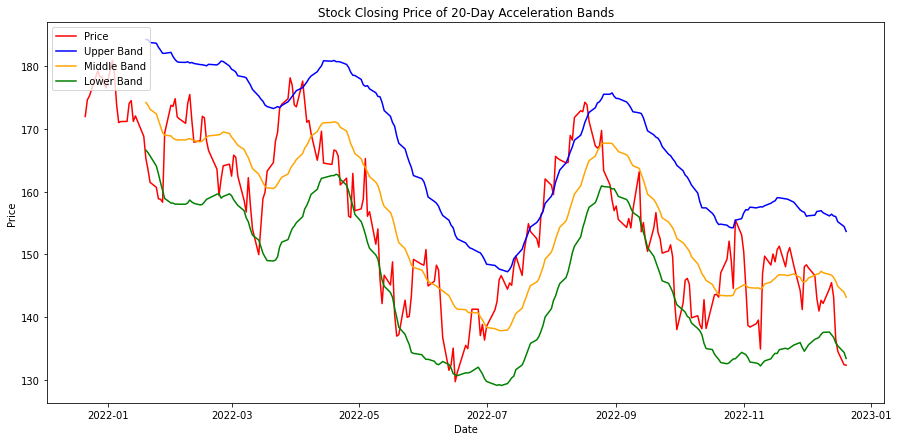

In [132]:
plt.figure(figsize=(15,7))
plt.plot(df['Adj Close'], c='red')
plt.plot(df['Upper_Band'], c='blue')
plt.plot(df['Middle_Band'], c='orange')
plt.plot(df['Lower_Band'], c='green')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Stock Closing Price of ' + str(n) + '-Day Acceleration Bands')
plt.legend(['Price', 'Upper Band', 'Middle Band', 'Lower Band'], loc='upper left');
plt.show()

In [133]:
from matplotlib import dates as mdates
dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
from mplfinance.original_flavor import candlestick_ohlc

# With candlesticks

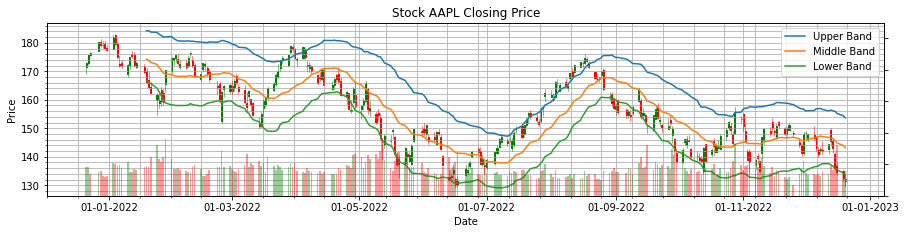

In [134]:
fig = plt.figure(figsize=(15,7))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.plot(df['Upper_Band'], label='Upper Band')
ax1.plot(df['Middle_Band'], label='Middle Band')
ax1.plot(df['Lower_Band'], label='Lower Band')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.legend(loc='best')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')
plt.show()

# Strategy for Trading


We go short on the stock when the price crosses the upper band indicating high volatility in overbought region

We go long on the stock when the price crosses the lower band indicating high volatility in oversold region

In [135]:
#Dataframe for trading signals
def signal_acc(data):
  signals = pd.DataFrame(data)
  signals['signals1'] = np.select([signals['Close'] >signals['Upper_Band'], signals['Close'] < signals['Lower_Band']], [-1, 1], default=0)
  signals['positions1'] = signals['signals1'].diff()
  return signals


In [136]:
signal = signal_acc(df)

In [158]:
signal.tail()

,Open,High,Low,Close,Adj Close,Volume,Chaikin,signals1,positions1,Upper_Band,Middle_Band,Lower_Band
Date,,,,,,,,,,,,
2022-12-14,145.350006,146.660004,141.160004,143.210007,143.210007,82291200,-1.978138e+07,0,0.0,156.097988,146.3085,136.735485
2022-12-15,141.110001,141.800003,136.029999,136.500000,136.500000,98931900,-3.908931e+07,0,0.0,156.023232,145.6940,135.863228
2022-12-16,136.690002,137.649994,133.729996,134.509995,134.509995,160080100,-6.743427e+07,1,1.0,155.186849,144.8835,135.379346
2022-12-19,135.110001,135.199997,131.320007,132.369995,132.369995,79592600,-5.816767e+07,1,0.0,154.430034,143.9375,134.335033
2022-12-20,131.389999,133.250000,129.889999,132.300003,132.300003,77256200,-7.742796e+06,1,0.0,153.646970,143.1520,133.374467


In [138]:
def plot_signals(signals):
  # visualize trading signals and position
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)   
  bx2 = bx.twinx()
  #plot two different assets
  l1, = bx.plot(signals['Close'], c='#4abdac')
  u1, = bx.plot(signals['Close'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
  u1, = bx.plot(signals['Close'][signals['positions1'] == -1], lw=0, marker='^', markersize=8, c='r',alpha=0.7)
  plt.legend(['Price','Buy Signal','Sell Signal'])


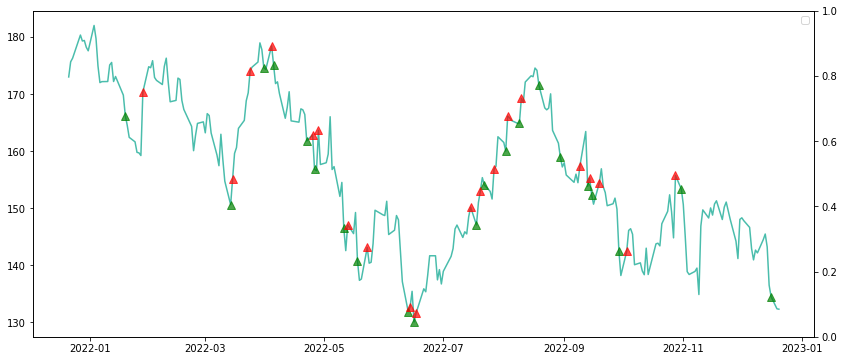

In [139]:
plot_signals(signal)

# Calculating CAGR and PNL

In [140]:
def pnl_calculation(signals):

  initial_capital = 100000

  # shares to buy for each position 
  positions1 = initial_capital// max(signals['Close']) 

  #pnl for the 1st asset
  portfolio = pd.DataFrame()
  portfolio['asset1'] = signals['Close']
  portfolio['holdings1'] = signals['positions1'].cumsum() * signals['Close'] * positions1
  portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['Close'] * positions1).cumsum()
  portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total asset1'].pct_change()
  portfolio['positions1'] = signals['positions1']

  portfolio['total asset'] = portfolio['total asset1']
  portfolio = portfolio.dropna()

  return portfolio

In [141]:
portfolio = pnl_calculation(signal)

In [142]:
portfolio

,asset1,holdings1,cash1,total asset1,return1,positions1,total asset
Date,,,,,,,
2021-12-23,176.279999,0.000000,100000.000000,100000.000000,0.000000,0.0,100000.000000
2021-12-27,180.330002,0.000000,100000.000000,100000.000000,0.000000,0.0,100000.000000
2021-12-28,179.289993,0.000000,100000.000000,100000.000000,0.000000,0.0,100000.000000
2021-12-29,179.380005,0.000000,100000.000000,100000.000000,0.000000,0.0,100000.000000
2021-12-30,178.199997,0.000000,100000.000000,100000.000000,0.000000,0.0,100000.000000
...,...,...,...,...,...,...,...
2022-12-14,143.210007,0.000000,114707.714691,114707.714691,0.000000,0.0,114707.714691
2022-12-15,136.500000,0.000000,114707.714691,114707.714691,0.000000,0.0,114707.714691
2022-12-16,134.509995,73845.986984,40861.727707,114707.714691,0.000000,1.0,114707.714691


In [143]:
def calculate_cagr(portfolio):

  # calculate CAGR
  final_portfolio = portfolio['total asset'].iloc[-1]
  initial_portfolio = portfolio['total asset'].iloc[0]
  delta = (portfolio.index[-1] - portfolio.index[0]).days
  print('Number of days = ', delta)
  YEAR_DAYS = 365
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [144]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))

Number of days =  362
CAGR = 13.614%


# Chaikin Osscilator

The Chaikin Oscillator is essentially a momentum indicator, but of the Accumulation-Distribution line rather than mere price. It looks at both the strength of price moves and the underlying buying and selling pressure during a given time period.

In [145]:
symbol = 'AAPL'
start = dt.date.today() - dt.timedelta(days = 365)
end = dt.date.today()


In [146]:
df = yf.download(symbol,start,end)


[*********************100%***********************]  1 of 1 completed


In [147]:
#defining exponential moving average
def ema(s: pd.Series, period: int = 9) -> pd.Series:
    return s.ewm(span=period).mean()

The oscillator builds on the concept of moving average convergence divergence or MACD. MACD is derived from the moving average, which is the mean price of an issue over a certain period.

The transition from MACD to Chaikin Oscillator requires several steps. The Chaikin Oscillator was created in reference to the accumulation/distribution, another Chaikin brainchild. The acc/dis line builds on the money flow multiplier, which attempts to quantify the amount of money coming into the market and its impact on stock prices. 

The multiplier formula is as follows: 

$f = \frac{[(\text{Close} - \text{ Low}) - (\text{High} - \text{ Close})]} {(\text{High} - \text{ Low})}$
​


In [148]:
def chaikin_oscillator(df):
    """Calculate Chaikin Oscillator for given data.
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) * df['Volume'] / (df['High'] - df['Low'])
    ad = ad + ad.shift(1)

    ema3 = ema(ad,3);
    ema10 = ema(ad,10);

    Chaikin = pd.Series((ema3-ema10), name='Chaikin')

    df = df.join(Chaikin)
    return df

In [149]:
df = chaikin_oscillator(df)

In [150]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Chaikin
Date,,,,,,,
2021-12-21,171.559998,173.199997,169.119995,172.990005,171.991791,91185900,NaN
2021-12-22,173.039993,175.860001,172.149994,175.639999,174.626495,92135300,0.000000e+00
2021-12-23,175.850006,176.850006,175.270004,176.279999,175.262802,68356600,-7.322474e+06
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.289459,74919600,-9.671247e+06
2021-12-28,180.160004,181.330002,178.529999,179.289993,178.255447,79144300,-2.047156e+07


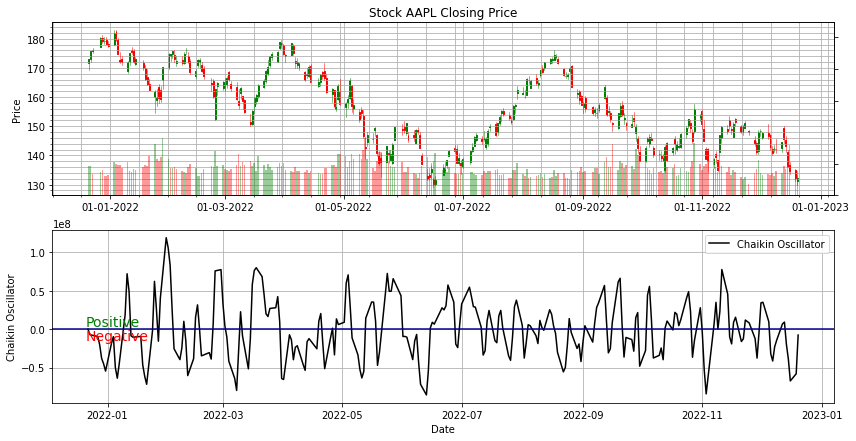

In [151]:
# ## Candlestick with Chaikin Oscillator
from matplotlib import dates as mdates

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = mdates.date2num(dfc['Date'].tolist())
from mplfinance.original_flavor import candlestick_ohlc
fig = plt.figure(figsize=(14,7))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['Chaikin'], label='Chaikin Oscillator', color='black')
ax2.axhline(y=0, color='darkblue')
ax2.text(s='Positive', x=dfc.Date[0], y=1, verticalalignment='bottom', fontsize=14, color='green')
ax2.text(s='Negative', x=dfc.Date[0], y=1, verticalalignment='top', fontsize=14, color='red')
ax2.grid()
ax2.legend(loc='best')
ax2.set_ylabel('Chaikin Oscillator')
ax2.set_xlabel('Date')
plt.show()

# Strategy for trading

A reading above Zero Indicates buying pressure(overbought) and a reading below zero indicates selling pressure(oversold)

## Generate trading signals

In [152]:
#Dataframe for trading signals
def signal_chaikin(data):
  signals = pd.DataFrame(data)
  signals['signals1'] = np.select([signals['Chaikin'] >0, signals['Close'] < 0], [-1, 1], default=0)
  signals['positions1'] = signals['signals1'].diff()
  return signals


In [153]:
signals = signal_chaikin(df)

In [154]:
signals.tail()

,Open,High,Low,Close,Adj Close,Volume,Chaikin,signals1,positions1
Date,,,,,,,,,
2022-12-14,145.350006,146.660004,141.160004,143.210007,143.210007,82291200,-1.978138e+07,0,1.0
2022-12-15,141.110001,141.800003,136.029999,136.500000,136.500000,98931900,-3.908931e+07,0,0.0
2022-12-16,136.690002,137.649994,133.729996,134.509995,134.509995,160080100,-6.743427e+07,0,0.0
2022-12-19,135.110001,135.199997,131.320007,132.369995,132.369995,79592600,-5.816767e+07,0,0.0
2022-12-20,131.389999,133.250000,129.889999,132.300003,132.300003,77256200,-7.742796e+06,0,0.0


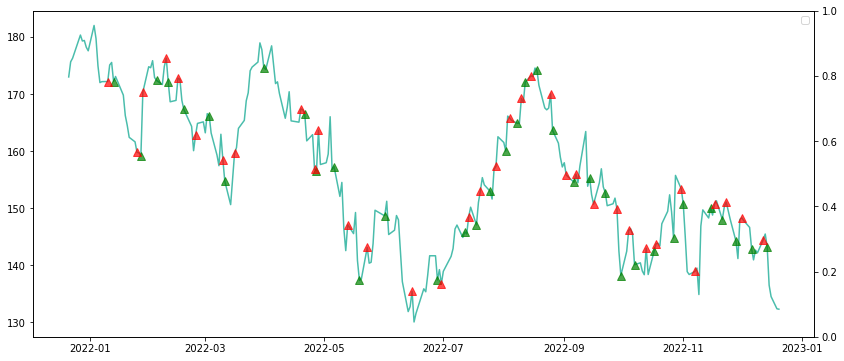

In [159]:
plot_signals(signals)

PNL and CAGR calculation

In [155]:
portfolio = pnl_calculation(signals)

In [156]:
portfolio.tail()

,asset1,holdings1,cash1,total asset1,return1,positions1,total asset
Date,,,,,,,
2022-12-14,143.210007,0.0,111666.258377,111666.258377,0.011236,1.0,111666.258377
2022-12-15,136.500000,0.0,111666.258377,111666.258377,0.000000,0.0,111666.258377
2022-12-16,134.509995,0.0,111666.258377,111666.258377,0.000000,0.0,111666.258377
2022-12-19,132.369995,0.0,111666.258377,111666.258377,0.000000,0.0,111666.258377
2022-12-20,132.300003,0.0,111666.258377,111666.258377,0.000000,0.0,111666.258377


In [157]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))

Number of days =  362
CAGR = 11.768%
